# Seminal Work: Classification of objects with deposit using a RaspberryPi
Autoren: Sofie Scharaf, Dominic Viola

## Step 0: Prerequisits

In [ ]:
!python --version

Python 3.10.14


In [ ]:
# prerequisits
#!pip install numpy pandas opencv-python tensorflow==2.16.1 tensorboard # if on Apple silicon also use this: tensorflow-metal

In [48]:
# imports and set seed so results are random, but stil reproducable
import tensorflow as tf
import keras

import tensorflow.keras.layers as layers
from sklearn.preprocessing import OneHotEncoder
import random
import os  # Helps you manage files and folders
import sys
import cv2  # Working with images
import numpy as np
import matplotlib.pyplot as plt  # To plot images
import datetime
from PIL import Image
import cv2

# we need Keras 2 because TF 2.16.1 does not work with Keras 3 if we want to save a model / this workaround does not work (at leased on M1 chips)
os.environ["TF_USE_LEGACY_KERAS"] = "1"

print("tensorflow version: "+ tf.__version__)
print("keras version: ", keras.__version__)

def set_seed(seed=0):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  random.seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = "1"
  os.environ['TF_CUDNN_DETERMINISM'] = "1"
  os.environ['PYTHONHASHSEED'] = str(seed)
  keras.utils.set_random_seed(seed)

set_seed()

tensorflow version: 2.16.1
keras version:  3.4.1


## Step 1: Find Datasets
We want to train a model to recognize and classify different kinds of Cans and bottles.
This will later be used in an IoT system that displays the price one would get for a certain type of can or bottle.

Hence, we need some training data to fine tune an existing model to recognize these classes.
Therefore, we download a dataset that contains can and bottle data, so that we can fine tune a model to recognize and classify them. 
Later on we may need some real world images of the actual cans we want to use our system on.

The CIFAR-100 dataset has come classes in the food_container superclass, that may be interesting for this use-case:
- bottles 
- cans 
- cups

See https://www.cs.toronto.edu/~kriz/cifar.html

Considerations that have to be made: 
1. Train only with the relevant classes and then also train with more classes to see if it improves the model ?
1. Add an additional class for other objects than cans and bottles to prevent many false positives ?
1. Pointwise Convolution in Model Head?



In [2]:
# download the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode="fine")

In [3]:
label_names = [
    "apple",
    "aquarium_fish",
    "baby",
    "bear",
    "beaver",
    "bed",
    "bee",
    "beetle",
    "bicycle",
    "bottle",
    "bowl",
    "boy",
    "bridge",
    "bus",
    "butterfly",
    "camel",
    "can",
    "castle",
    "caterpillar",
    "cattle",
    "chair",
    "chimpanzee",
    "clock",
    "cloud",
    "cockroach",
    "couch",
    "crab",
    "crocodile",
    "cup",
    "dinosaur",
    "dolphin",
    "elephant",
    "flatfish",
    "forest",
    "fox",
    "girl",
    "hamster",
    "house",
    "kangaroo",
    "keyboard",
    "lamp",
    "lawn_mower",
    "leopard",
    "lion",
    "lizard",
    "lobster",
    "man",
    "maple_tree",
    "motorcycle",
    "mountain",
    "mouse",
    "mushroom",
    "oak_tree",
    "orange",
    "orchid",
    "otter",
    "palm_tree",
    "pear",
    "pickup_truck",
    "pine_tree",
    "plain",
    "plate",
    "poppy",
    "porcupine",
    "possum",
    "rabbit",
    "raccoon",
    "ray",
    "road",
    "rocket",
    "rose",
    "sea",
    "seal",
    "shark",
    "shrew",
    "skunk",
    "skyscraper",
    "snail",
    "snake",
    "spider",
    "squirrel",
    "streetcar",
    "sunflower",
    "sweet_pepper",
    "table",
    "tank",
    "telephone",
    "television",
    "tiger",
    "tractor",
    "train",
    "trout",
    "tulip",
    "turtle",
    "wardrobe",
    "whale",
    "willow_tree",
    "wolf",
    "woman",
    "worm"
]

In [4]:
# select the classes we want
train_labels = [label_names[int(idx)] for idx in y_train]
test_labels = [label_names[int(idx)] for idx in y_test]
test_labels

/var/folders/f_/mtgsl6n13zd4n7z20x96lx1m0000gn/T/ipykernel_77512/939403219.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_labels = [label_names[int(idx)] for idx in y_train]
/var/folders/f_/mtgsl6n13zd4n7z20x96lx1m0000gn/T/ipykernel_77512/939403219.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_labels = [label_names[int(idx)] for idx in y_test]


['mountain',
 'forest',
 'seal',
 'mushroom',
 'sea',
 'tulip',
 'camel',
 'butterfly',
 'cloud',
 'apple',
 'sea',
 'skunk',
 'streetcar',
 'rocket',
 'lamp',
 'lion',
 'tulip',
 'wolf',
 'rose',
 'orange',
 'rose',
 'mountain',
 'skunk',
 'dinosaur',
 'chimpanzee',
 'can',
 'keyboard',
 'bicycle',
 'bicycle',
 'rose',
 'chair',
 'plate',
 'lawn_mower',
 'turtle',
 'palm_tree',
 'shark',
 'pickup_truck',
 'boy',
 'couch',
 'house',
 'porcupine',
 'cockroach',
 'mountain',
 'shark',
 'palm_tree',
 'clock',
 'lawn_mower',
 'pickup_truck',
 'skunk',
 'castle',
 'beaver',
 'bee',
 'bottle',
 'pear',
 'baby',
 'flatfish',
 'sea',
 'oak_tree',
 'leopard',
 'rocket',
 'snail',
 'crocodile',
 'camel',
 'rabbit',
 'beetle',
 'girl',
 'lion',
 'sunflower',
 'porcupine',
 'tulip',
 'raccoon',
 'train',
 'ray',
 'trout',
 'flatfish',
 'flatfish',
 'sunflower',
 'bowl',
 'snail',
 'clock',
 'sea',
 'snake',
 'orchid',
 'bee',
 'dinosaur',
 'tractor',
 'snake',
 'forest',
 'boy',
 'ray',
 'clock',


<BarContainer object of 100 artists>

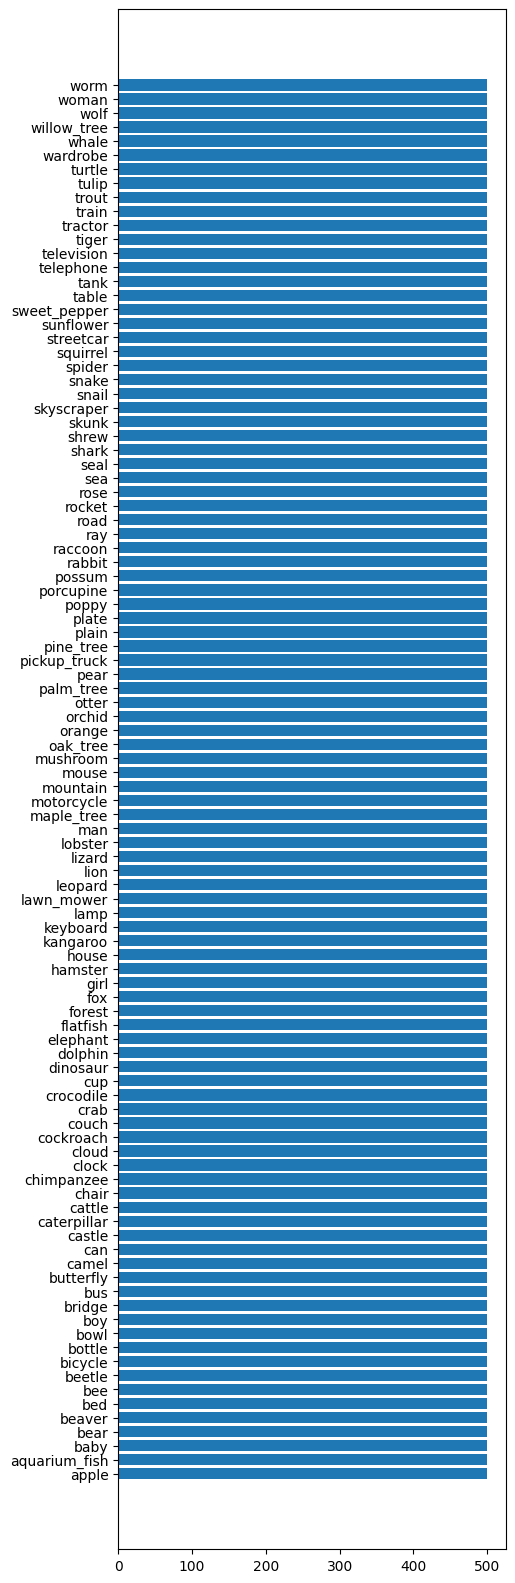

In [5]:
# see how many instances of each class there are
values, counts  = list(np.unique(train_labels, return_counts=True))
class_frequency = list(zip(list(values), list(counts)))

plt.figure(figsize=(5, 20))
plt.barh(y=values, width=counts)

The classes are already balanced, so there is no need to modify the balance within the dataset

In [6]:
def filter_classes(classes: list, x_train: np.array, y_train: np.array, x_test: np.array, y_test: np.array):
    """
    Filter the dataset for the specified class names from the dataset. All other entries will be droped.
    """
    # normalize labels to create a mask
    norm_y_train = y_train.T[0].tolist()
    norm_y_test = y_test.T[0].tolist()

    # the class ids that are used in y_train, y_test
    select_labels = []
    for class_name in classes:
        assert class_name in label_names, f"The class with the name '{class_name}' doesnt exist."
        select_labels.append(label_names.index(class_name))
    
    # select train data points
    train_mask = np.isin(norm_y_train, select_labels)
    
    # select test data points
    test_mask = np.isin(norm_y_test, select_labels)

    return x_train[train_mask], y_train[train_mask], x_test[test_mask], y_test[test_mask]

x_train, y_train, x_test, y_test = filter_classes(["can", "bottle", "cup"], x_train, y_train, x_test, y_test)

In [7]:
def convert_label_ids_to_names(y):
    """
    Converts the ids to the associated label names in the original dataset. Those are not one-hot-labels.

    Input:
    ---
    y: the labels in index form; The index corresponds to the class name as a string in the label_names variable

    Output:
    ---
    output: list of string names of the classes
    """
    output = []
    for l in range(len(y)):
        output.append(label_names[y.T[0][l]])
    return output

#print(y_test)
print(list(zip(y_test, convert_label_ids_to_names(y_test))))

[(array([16]), 'can'), (array([9]), 'bottle'), (array([9]), 'bottle'), (array([16]), 'can'), (array([9]), 'bottle'), (array([28]), 'cup'), (array([28]), 'cup'), (array([16]), 'can'), (array([16]), 'can'), (array([28]), 'cup'), (array([16]), 'can'), (array([28]), 'cup'), (array([9]), 'bottle'), (array([28]), 'cup'), (array([16]), 'can'), (array([16]), 'can'), (array([9]), 'bottle'), (array([28]), 'cup'), (array([9]), 'bottle'), (array([9]), 'bottle'), (array([28]), 'cup'), (array([16]), 'can'), (array([16]), 'can'), (array([9]), 'bottle'), (array([16]), 'can'), (array([28]), 'cup'), (array([9]), 'bottle'), (array([28]), 'cup'), (array([9]), 'bottle'), (array([9]), 'bottle'), (array([16]), 'can'), (array([28]), 'cup'), (array([9]), 'bottle'), (array([16]), 'can'), (array([28]), 'cup'), (array([9]), 'bottle'), (array([9]), 'bottle'), (array([28]), 'cup'), (array([16]), 'can'), (array([28]), 'cup'), (array([28]), 'cup'), (array([28]), 'cup'), (array([16]), 'can'), (array([9]), 'bottle'), (

In [8]:
def labels_to_one_hot(y_train: np.array, y_test:np.array):
    """
    Takes in the class id labels and converts them to one-hot encoded representations.

    output:
    ---
    one_hot_train: One Hot encoded version of the first input 
    one_hot_test: One Hot encoded version of the second input
    categories: A list of the label names; the index in the one hot entry in a vector is equivalent to the index of the corresponding label name in this list
    """
    # preprocess to label names instead of label ids
    y_train_labels = convert_label_ids_to_names(y_train)
    y_test_labels = convert_label_ids_to_names(y_test)

    # to avoid giving the y_train and y_test different one hot locations for the same class, we will combine them into one vector and split them up again afterwards, so the one-hot vectors are consistent between train and test
    y_combined = np.concatenate([y_train_labels, y_test_labels])
    # create a second dimension since OneHotEncoder requires 2D input 
    y_combined = y_combined.reshape(-1, 1)

    encoder = OneHotEncoder(sparse_output=False) #dont use sparse vectors as the output
    y_combined_encoded = encoder.fit_transform(y_combined)
    
    #print(encoder.categories_)

    #split the combined array into train and test labels again
    split_idx = len(y_train)
    one_hot_train, one_hot_test = np.split(y_combined_encoded, [split_idx])
    #print(one_hot_train)

    assert len(one_hot_train) == len(y_train), "Length missmatch between train and one_hot_train"
    assert len(one_hot_test) == len(y_test), "Length missmatch between test and one_hot_test"
    return one_hot_train, one_hot_test, encoder.categories_[0] #categories is shape 1xnum_categories so we need to read 0 to remove the first dim

In [9]:
def one_hot_to_labels(y, categories):
    """
    Input
    ---
    y: The one hot labels of shape num_classes X num_examples
    categories: The categories that the OneHotEncoder returned to convert the one-hot-positions to the corresponding label name

    Output
    ---
    out: The labels y but converted from the one-hot representation to the label names container in categories
    """
    label_idxs = np.argmax(y, axis = 1)
    #print("argmax", label_idxs)
    #print("categories", categories)
    out = []
    for idx in label_idxs:
        out.append(categories[idx])
    return out


In [10]:
one_hot_train, one_hot_test, hot_idx_to_label = labels_to_one_hot(y_train, y_test)

# validate that everything works as intended
orig = convert_label_ids_to_names(y_train)
decoded = one_hot_to_labels(one_hot_train, hot_idx_to_label)
print("Len:", len(orig), len(decoded))
print("original X one-hot\n", list(zip(orig, decoded)))

Len: 1500 1500
original X one-hot
 [('cup', 'cup'), ('bottle', 'bottle'), ('cup', 'cup'), ('cup', 'cup'), ('bottle', 'bottle'), ('cup', 'cup'), ('cup', 'cup'), ('cup', 'cup'), ('bottle', 'bottle'), ('bottle', 'bottle'), ('cup', 'cup'), ('can', 'can'), ('can', 'can'), ('bottle', 'bottle'), ('can', 'can'), ('bottle', 'bottle'), ('can', 'can'), ('cup', 'cup'), ('can', 'can'), ('cup', 'cup'), ('cup', 'cup'), ('bottle', 'bottle'), ('cup', 'cup'), ('bottle', 'bottle'), ('can', 'can'), ('cup', 'cup'), ('can', 'can'), ('bottle', 'bottle'), ('cup', 'cup'), ('bottle', 'bottle'), ('cup', 'cup'), ('can', 'can'), ('cup', 'cup'), ('cup', 'cup'), ('bottle', 'bottle'), ('cup', 'cup'), ('cup', 'cup'), ('can', 'can'), ('bottle', 'bottle'), ('can', 'can'), ('can', 'can'), ('can', 'can'), ('can', 'can'), ('bottle', 'bottle'), ('can', 'can'), ('bottle', 'bottle'), ('can', 'can'), ('cup', 'cup'), ('bottle', 'bottle'), ('cup', 'cup'), ('can', 'can'), ('can', 'can'), ('cup', 'cup'), ('cup', 'cup'), ('bottle',

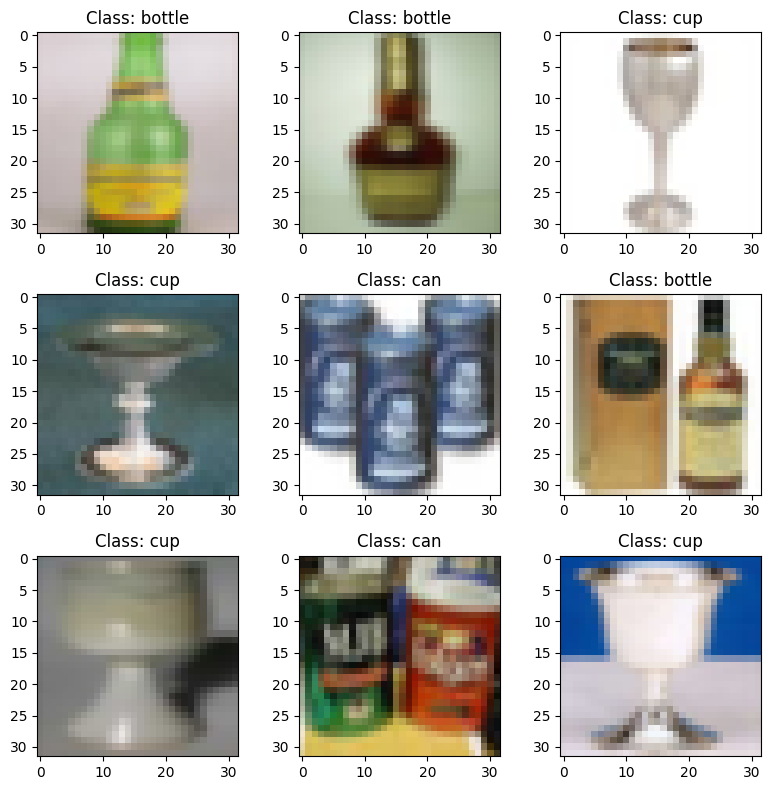

In [11]:
# visualize the remaining data
fig, ax = plt.subplots(3,3)
fig.set_size_inches(8,8)
for i in range(3):
    for j in range (3):
        l = random.randint(0, len(y_test))
        ax[i,j].imshow(x_test[l])
        ax[i,j].set_title('Class: ' + label_names[y_test.T[0][l]])

plt.tight_layout()

## Step 2: Create a Data Augmentation pipeline

In [12]:
def create_data_augmentation_pipeline(input_layer = None):
    if input_layer == None:
        input_layer = layers.Input(shape=(32,32,3))
    
    pipeline = layers.RandomFlip("horizontal_and_vertical")(input_layer)
    pipeline = layers.RandomRotation(0.2)(pipeline)
    pipeline = layers.RandomZoom((0, -0.25))(pipeline) #zooms in horizontal and vertical direction and preserves aspect ratio
    pipeline_out = layers.RandomBrightness((-0.2, 0.2), value_range=[0, 255], dtype=tf.int16)(pipeline) # increase and decrease between 20%
    # output datatype cannot be unsigned int, because the clipping of the RandomBrightness will not be bale to handle overflow of the color channels, but if there is a negative range the clipping works

    return tf.keras.Model(input_layer, pipeline_out)

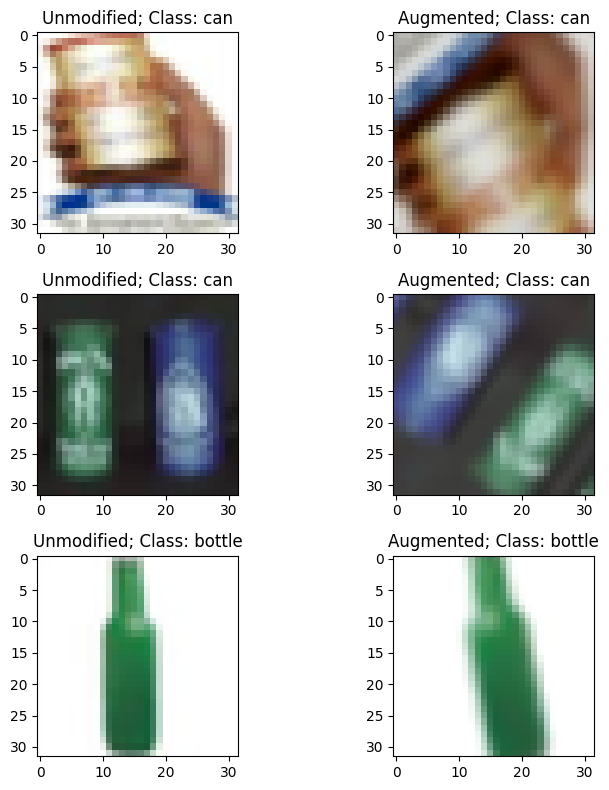

In [13]:
# test the data augmentation pipeline

fig, ax = plt.subplots(3,2)
fig.set_size_inches(8,8)
for i in range(3):
    l = random.randint(0, len(y_test)-1)
    sample = x_test[l]
    #print("Original:", sample)
    ax[i,0].imshow(sample)
    ax[i,0].set_title('Unmodified; Class: ' + label_names[y_test.T[0][l]])

    augmented = create_data_augmentation_pipeline()(sample[None, :]) # add batch dim (required by the model)
    augmented = np.squeeze(augmented) # remove batch dimenstion (required by matplotlib)
    #print("augmented:", augmented)
    ax[i,1].imshow(augmented)
    ax[i,1].set_title('Augmented; Class: ' + label_names[y_test.T[0][l]])

plt.tight_layout()

## Step 3: Select a backbone
Since the model will be deployed on a RaspberryPi we need a model with few parameters to respect the constraints of the IoT device.

In [14]:
def create_backbone(input_layer = None):
    if input_layer is None:
        input_layer = tf.keras.Input(shape=(32, 32, 3))
    # select the backbone model that will be placed on the Raspberry Pi
    return tf.keras.applications.MobileNetV3Large(
        alpha=1.0,
        minimalistic=False,
        include_top=False, #remove the head; only use as backbone
        weights="imagenet",
        input_tensor=input_layer,
        #classes=3, # cup, bottle, can

        pooling=None,
        dropout_rate=0.2,
        #classifier_activation="softmax",
        include_preprocessing=True,
)


In [15]:
# freeze backbone
#mobile_net_backbone.trainable = False

# construct the workflow for fine-tuning
input_shape = (32, 32, 3)
input_layer = tf.keras.Input(shape=input_shape)

back = create_backbone(input_layer)
back.trainable = False

# head
x = layers.Flatten()(back.output)
x = layers.Dropout(0.2)(x)
output = layers.Dense(3, activation="softmax")(x) # cup, bottle, can


# create model with the head
model = tf.keras.Model(input_layer, output)

/Users/dom/miniconda3/envs/image-iot/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [16]:
# to use the CategoricalCrossentropy we need to convert our labels into one hot encoded representation, instead of the indices of the class
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

In [17]:
model.summary()
#mobile_net_backbone.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 32, 32, 3) │          0 │ input_layer_3[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 16, 16,    │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 16, 16,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 16, 16,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 16, 16,    │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 16, 16,    │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 16, 16,    │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 16, 16,    │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 17, 17,    │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 8, 8, 64)  │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 8, 8, 64)  │        256 │ expanded_conv_1_

 Total params: 2,999,235 (11.44 MB)

 Trainable params: 2,883 (11.26 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

## Step 4: Fine-Tune and Transfer Learning
Now we use our cup, bottle and can data to fine tune the new model head that we have attached to our MobileNetV3 backbone. 
Afterwards we will fine tune the entire model weights.

In [18]:
# conversion to one-hot representation is needed by CategoricalCrossEntropy
one_hot_train, one_hot_test, hot_idx_to_label = labels_to_one_hot(y_train, y_test)

def train_model(model: tf.keras.Model = None, checkpoint_name: str = None, load_from_checkpoint: bool = True, 
                preprocessing_pipeline: tf.keras.Model = None,
                epochs: int = 10, patience: int = 50, monitored_metric: str ='val_loss', lr: float = 1e-03):
    """
    Train a model object from scratch or continue training it from a checkpoint in the checkpoints folder.
    Parameters for early stopping and saving the resulting model to a checkpoint can be set. 
    The checkpoint created will have the filetype ".keras" and fill be post-fixed with the number of epochs trained.

    NOTE: 
    - either model or checkpoint_name must be defined. If checkpoint is provided and found in "checkpoints" folder while "load_from_checkpoint" is true the provided model variable will be ignored.
    - Dont use "_" or ".keras" in the name of checkpoints these might break the checkpointing logic.

    Input:
    ---
    model: the keras.Model that should be trained, optional if a checkpoint is provided
    checkpoint_name: the name of a checkpoint without the epoch prefix and file_format. If the checkpoint does not exist it will be created after the model variable was trained.
    load_from_checkpoints: set this to false if you only want to use the checkpoint for saving the final model, but not to load from an existing checkpoint. Ignore this if you do not use "checkpoint_name".
    preprocessing_pipeline: preprocesses the images e.g. Data Augmentation before feeding it into the model for training
    epochs: num of epochs the model should be trained
    patience: patience in the early stopping process
    monitored_metric: the metric that will be used to determined early stopping and the best model checkpoint

    Output:
    ---
    model: the trained model instance without the preprocessing pipeline
    history: the training history, which can be used to visualize the training process
    """
    assert model is not None or checkpoint_name is not None, "Error: Either model or checkpoint_name must be defined!"

    # vars
    goal_epochs = epochs

    #####################
    ## Load Checkpoint ##
    #####################
    # load latest checkpoint is checkpoint name exists and load_from_checkpoint is true
    os.makedirs("checkpoints", exist_ok=True)
    checkpoints = os.listdir("checkpoints")
    if checkpoints != [] and load_from_checkpoint and checkpoint_name is not None:
        highest_epoch = 0
        highest_checkpoint = ""
        for checkpoint_full in checkpoints:
            if checkpoint_full.startswith(checkpoint_name):
                try:
                    dot_split = checkpoint_full.split(".")
                    curr_checkpoint_format = dot_split.pop(-1)
                    curr_checkpoint_name = ".".join(dot_split)
                    if curr_checkpoint_format == "keras":
                        curr_metric = curr_checkpoint_name.split("_")[-1]
                        current_epoch = int(curr_metric)
                        if current_epoch > highest_epoch:
                            highest_epoch = current_epoch
                            highest_checkpoint = checkpoint_full
                except:
                    continue
        if highest_checkpoint != "":
            #goal_epochs = epochs + highest_epoch
            print("Loading Model from checkpoint:", highest_checkpoint)
            model = tf.keras.saving.load_model(f"checkpoints/{highest_checkpoint}")
            #results = model.evaluate(x_test, one_hot_test)
            #print("Loaded model performance on eval data:", results)

        assert model is not None, "Error: You did not specify a model as input and it was not possible to load a model from checkpoint!"
        preprocessing_model = model
        
    else:
        # remove the input layer of the "model" since the preprocessing will have its own input layer
        model._layers.pop(0)
        # concatenate the preprocessing pipline to the beginning of the model, if it is not already loaded from the saved checkpoint
        preprocessing_model = tf.keras.Model(preprocessing_pipeline.input, model.output)
        
        preprocessing_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.CategoricalAccuracy()],
        )

    ###############
    # Train Model #
    ###############

    #preprocessing_pipeline.summary()
    #model.summary()

    # callbacks during training process
    early_stop_cb  = tf.keras.callbacks.EarlyStopping(monitor=monitored_metric, patience=patience)
    
    output_checkpoint = f"checkpoints/{checkpoint_name}_" + "{val_categorical_accuracy:.2f}_{epoch:03d}.keras"
    check_point_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=output_checkpoint, 
        save_weights_only=False, # entire model (config + weight) 
        monitor=monitored_metric, save_best_only=True
        )

    # only save the model that does not use preprocessing    

    log_dir = f"logs/fit/{checkpoint_name}_{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}"
    os.makedirs(log_dir, exist_ok=True)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, update_freq="epoch")

    history = preprocessing_model.fit(
        x=x_train, y=one_hot_train, epochs=epochs, 
        validation_data=(x_test, one_hot_test), 
        callbacks=[early_stop_cb, check_point_cb, tensorboard_callback]
    )
    
    return model, history

In [19]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6007 (pid 10457), started 1 day, 14:52:03 ago. (Use '!kill 10457' to kill it.)

In [21]:
model, history = train_model(model, "mobileNetV3Large-FullyConnected-test", epochs=1, preprocessing_pipeline=create_data_augmentation_pipeline(input_layer))

2024-07-11 13:42:45.227151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 176ms/step - categorical_accuracy: 0.3840 - loss: 1.3975 - val_categorical_accuracy: 0.5200 - val_loss: 0.9819


In [19]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 32, 32, 3) │          0 │ input_layer_3[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 16, 16,    │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 16, 16,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 16, 16,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 16, 16,    │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 16, 16,    │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 16, 16,    │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 16, 16,    │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 17, 17,    │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 8, 8, 64)  │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 8, 8, 64)  │        256 │ expanded_conv_1_

 Total params: 2,999,235 (11.44 MB)

 Trainable params: 2,883 (11.26 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [55]:
# fine tune the entire model with a lower learning rate
# set all model weights to be trainable and compile again for the changes to take effect

# this does not work
#model.trainable = True

for l in range(len(model.layers)):
    model.layers[l].trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 32, 32, 3) │          0 │ input_layer_3[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 16, 16,    │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 16, 16,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 16, 16,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 16, 16,    │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 16, 16,    │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 16, 16,    │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 16, 16,    │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 17, 17,    │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 8, 8, 64)  │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 8, 8, 64)  │        256 │ expanded_conv_1_

 Total params: 2,999,235 (11.44 MB)

 Trainable params: 2,974,835 (11.35 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [56]:
model, history = train_model(model, "mobileNetV3Large-FullyConnected-fine-tuned", epochs=100, lr=1e-04, preprocessing_pipeline=create_data_augmentation_pipeline(input_layer))

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 246s 4s/step - categorical_accuracy: 0.4290 - loss: 6.1203 - val_categorical_accuracy: 0.3767 - val_loss: 3.9682
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - categorical_accuracy: 0.6450 - loss: 1.6355 - val_categorical_accuracy: 0.4667 - val_loss: 11.3351
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - categorical_accuracy: 0.7856 - loss: 0.8865 - val_categorical_accuracy: 0.4867 - val_loss: 20.3639
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - categorical_accuracy: 0.8713 - loss: 0.4655 - val_categorical_accuracy: 0.5300 - val_loss: 4.8804
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - categorical_accuracy: 0.9296 - loss: 0.2160 - val_categorical_accuracy: 0.5467 - val_loss: 2.5179
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - categorical_accuracy: 0.9648 - loss: 0.1406 - val_categorical_accuracy: 0.5767 - val_loss: 2.0986
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - categorical_accuracy: 0.9809 - loss: 0

In [19]:
# list the data captured by the history
print(history.history.keys())
print("Best val_accuracy:", max(history.history['val_categorical_accuracy'])*100, "%")
#print("Best Val F1 score", max_val_f1*100, "%")
print("Best val_loss:", min(history.history['val_loss']))

NameError: name 'history' is not defined

Maybe we could train the head for even more epochs?

Evaluate the models performance

In [29]:
# load the checkpoint of the model again

# how to do predictions using the py
def predict(x):
    logits = model.predict(x)
    pred_id = np.argmax(logits)
    confidence = logits[0][pred_id]
    pred_str = hot_idx_to_label[pred_id]

    # confidence threshold (at leased 20% more confident than random chance)
    random_chance = 1/len(logits[0])
    threshold = 1.2 * random_chance
    if confidence < threshold:
        pred_str = "background"
    return confidence, pred_str

sample = x_test[None, 0]
#x_test[None, 0]
predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


(0.6648482, 'cup')

In [40]:
# since the conversion to tflite did not work we prepare everything else that can be combined in one script on the RaspberryPi

# make sure tensorflow 2.16.1, numpy and keras 3.4.1 are installed
class InferenceModel():
    """
    Class that makes it possible to load a checkpoint from a ".keras" checkpoint and use this model for inference
    """
    def __init__(self, checkpoint_path):
        self.hot_idx_to_label = ['bottle', 'can', 'cup']
        self.model = keras.saving.load_model(checkpoint_path)

    def predict(self, x, debug=False):
        # append a empty batch dimenstion if a single image is provided
        if len(x.shape) == 3:
            x = tf.expand_dims(x, axis=0)
            
        logits = self.model(x, training=False) #should be used instead of model.predict() for single samples
        logits = logits.numpy()
        pred_id = np.argmax(logits)
        confidence = logits[0][pred_id]
        pred_str = hot_idx_to_label[pred_id]

        # confidence threshold (at leased 20% more confident than random chance)
        random_chance = 1/len(logits[0])
        threshold = 1.2 * random_chance
        if confidence < threshold:
            pred_str = "background"
        if debug:
            print("predicted class '", pred_str, "' at index '", pred_id, "' from logits", logits)
            return confidence, pred_str
        return pred_str

infer = InferenceModel("checkpoints/mobileNetV3Large-FullyConnected-fine-tuned_0.81_042.keras")
infer.predict(x_test[0], debug=True)


predicted class ' can ' at index ' 1 ' from logits [[1.5074420e-18 1.0000000e+00 8.3644016e-16]]


(1.0, 'can')

predicted class ' bottle ' at index ' 0 ' from logits [[1.0000000e+00 7.5977168e-14 1.2367101e-17]]
predicted class ' cup ' at index ' 2 ' from logits [[1.3516014e-08 5.8758228e-06 9.9999416e-01]]
predicted class ' bottle ' at index ' 0 ' from logits [[0.83373135 0.14171447 0.02455418]]
predicted class ' bottle ' at index ' 0 ' from logits [[9.9976331e-01 2.1724234e-04 1.9380925e-05]]
predicted class ' can ' at index ' 1 ' from logits [[0. 1. 0.]]
predicted class ' bottle ' at index ' 0 ' from logits [[9.999945e-01 3.681727e-06 1.751956e-06]]
predicted class ' bottle ' at index ' 0 ' from logits [[9.9612278e-01 3.6596465e-03 2.1759229e-04]]
predicted class ' can ' at index ' 1 ' from logits [[1.3893578e-16 1.0000000e+00 6.9742490e-26]]
predicted class ' bottle ' at index ' 0 ' from logits [[9.9993944e-01 6.0493996e-05 1.2064716e-07]]


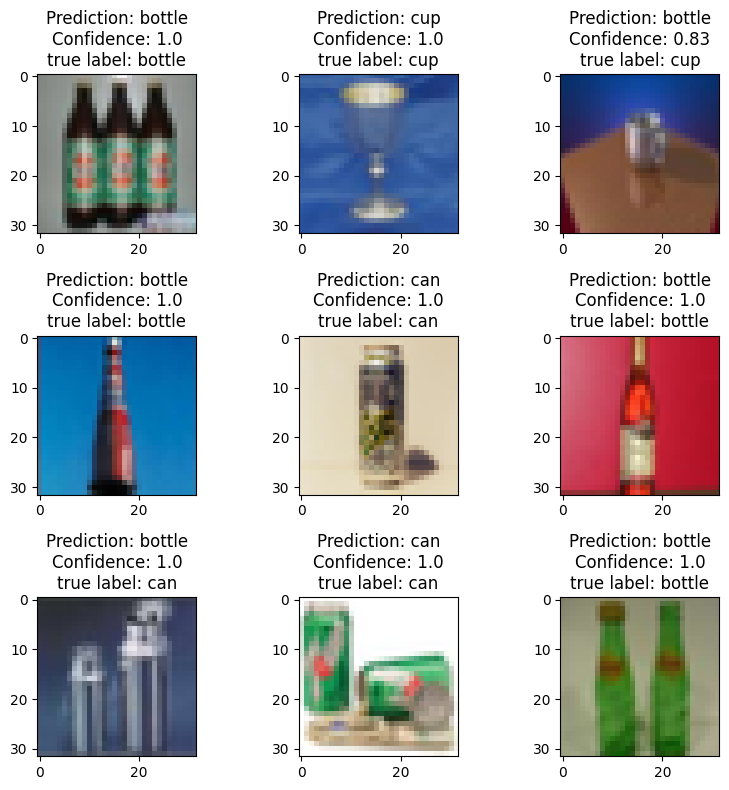

In [41]:
# get some predictions and visualize them
# test the data augmentation pipeline
fig, ax = plt.subplots(3,3)
fig.set_size_inches(8,8)
for i in range(3):
    for j in range(3):
        l = random.randint(0, len(y_test)-1)
        sample = x_test[l]
        conf, prediction = infer.predict(sample[None, :], debug=True)
        conf = str(round(conf, 2))
        #print("Original:", sample)
        ax[i,j].imshow(sample)
        ax[i,j].set_title(f'Prediction: {prediction}\nConfidence: {conf}\ntrue label: {label_names[y_test.T[0][l]]}')

plt.tight_layout()

Found 12 background images
predicted class ' bottle ' at index ' 0 ' from logits [[0.45824113 0.1246414  0.41711742]]
predicted class ' can ' at index ' 1 ' from logits [[0.35436624 0.584618   0.06101576]]
predicted class ' can ' at index ' 1 ' from logits [[0.06344943 0.9309746  0.00557601]]
predicted class ' cup ' at index ' 2 ' from logits [[0.01060014 0.26921004 0.72018987]]
predicted class ' can ' at index ' 1 ' from logits [[0.06344943 0.9309746  0.00557601]]
predicted class ' cup ' at index ' 2 ' from logits [[0.01585688 0.42785782 0.5562853 ]]
predicted class ' cup ' at index ' 2 ' from logits [[0.01585688 0.42785782 0.5562853 ]]
predicted class ' bottle ' at index ' 0 ' from logits [[0.45824113 0.1246414  0.41711742]]
predicted class ' bottle ' at index ' 0 ' from logits [[0.4681517  0.1629458  0.36890253]]


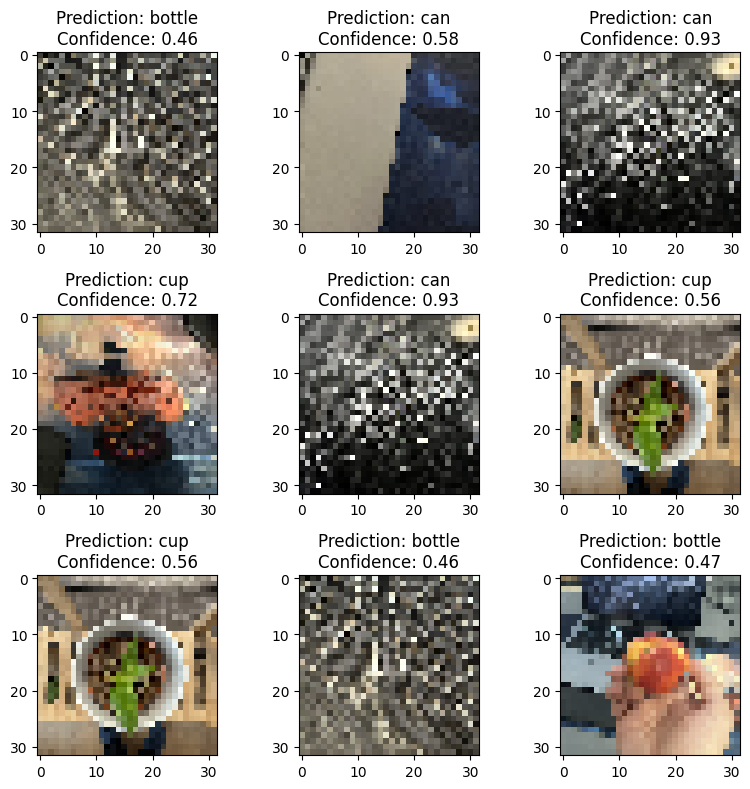

In [54]:
test_dir = "beispiele/background"
background_images = os.listdir(test_dir)
print(f"Found {len(background_images)} background images")

fig, ax = plt.subplots(3,3)
fig.set_size_inches(8,8)
for i in range(3):
    for j in range(3):
        idx = random.randint(0, len(background_images)-1)
        sample = cv2.imread(f"{test_dir}/{background_images[idx]}")
        sample = cv2.resize(sample, (32, 32), interpolation=cv2.INTER_NEAREST)
        sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

        conf, prediction = infer.predict(sample[None, :], debug=True)
        conf = str(round(conf, 2))
        #print("Original:", sample)
        ax[i,j].imshow(sample)
        ax[i,j].set_title(f'Prediction: {prediction}\nConfidence: {conf}')
plt.tight_layout()

We can see that the confidence for background images is lower in most instances. However, since none of them were predicted as backround, some futher tuning of the decision threshold should be done. 

## Step 4: Prepare the model for deployment on the RaspberryPi
We need to convert the model to tensorflow light and we have a limit of at most 8-bit weights to use the model on the Coral accelerator.

In [32]:
model.summary()

Model: "functional_70"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 32, 32, 3) │          0 │ input_layer_4[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 16, 16,    │        432 │ rescaling_2[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 16, 16,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_40       │ (None, 16, 16,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        144 │ activation_40[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_38 (ReLU)     │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        256 │ re_lu_38[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 16, 16,    │          0 │ activation_40[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 16, 16,    │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 16, 16,    │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_39 (ReLU)     │ (None, 16, 16,    │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 17, 17,    │          0 │ re_lu_39[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 8, 8, 64)  │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 8, 8, 64)  │        256 │ expanded_conv_1_

 Total params: 3,005,003 (11.46 MB)

 Trainable params: 2,883 (11.26 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

 Optimizer params: 5,768 (22.54 KB)

In [22]:
## NOTE: I cannot get this to work. No matter what workaround or fix I try it crashes without logs every time

# to convert the model to tflite we have to remove the data augmentation pipeline, otherwise we will get an error

# Convert the saved model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/f_/mtgsl6n13zd4n7z20x96lx1m0000gn/T/tmpxsigdtfo/assets


INFO:tensorflow:Assets written to: /var/folders/f_/mtgsl6n13zd4n7z20x96lx1m0000gn/T/tmpxsigdtfo/assets


: 